In [1]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import GRU, LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

#from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm
from keras.models import load_model
import nltk
from keras.callbacks import ModelCheckpoint, EarlyStopping
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu 
from nltk.translate.bleu_score import SmoothingFunction
from keras.utils import plot_model
from keras.layers import concatenate
import xlwt
from xlwt import Workbook

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
start1 = time()

In [0]:
project_path = "/content/drive/My Drive/Colab Notebooks/Capstone/Pre-work/X-ray-automation-v3/"

encoded_img_dir = "/content/drive/My Drive/Colab Notebooks/Capstone/Data/Indiana_dataset_all/encoded-xray-images/"
glove_dir = '/content/drive/My Drive/Colab Notebooks/Capstone/Data/'
frontal_descriptions = "/content/drive/My Drive/Colab Notebooks/Capstone/Data/Indiana_dataset_all/frontal_view_only/Frontal_descriptions.txt"
trainImages = '/content/drive/My Drive/Colab Notebooks/Capstone/Data/Indiana_dataset_all/frontal_view_only/All_train_images.txt'
valImages = '/content/drive/My Drive/Colab Notebooks/Capstone/Data/Indiana_dataset_all/frontal_view_only/Frontal_valImages.txt'
testImages = '/content/drive/My Drive/Colab Notebooks/Capstone/Data/Indiana_dataset_all/frontal_view_only/Frontal_testImages.txt'
images = '/content/drive/My Drive/Colab Notebooks/Capstone/Data/Indiana_dataset_all/images/All_frontal_images/'
all_descriptions_file = "/content/drive/My Drive/Colab Notebooks/Capstone/Data/Indiana_dataset_all/frontal_view_only/Frontal_descriptions.txt"

model_architechture = 'model_final_cnn_3lstm_20epch.png'
model_name = 'model_final_cnn_3lstm_20epch.h5'
excel_filename = 'Pred_final_CNN_3LSTM_20Epoch.xls'
epch = 20
l_r = 0.0001

In [5]:
os.chdir(project_path)
file_status = open(project_path+'Status.txt', 'a')
file_status.write('Start Time:' + str(start1) +'\n')

30

In [6]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# extract filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping

# parse descriptions
descriptions = load_descriptions(load_doc(all_descriptions_file))
print('Loaded: %d ' % len(descriptions))
print(descriptions)

Loaded: 3258 
{'CXR964_IM-2454-1001': ['In the interval, the heart size has become normal. Pulmonary XXXX are normal. Lungs are clear and expanded.'], 'CXR3607_IM-1781-1001': ['Heart size and pulmonary vascularity appear within normal limits. The patient is status post CABG. A few XXXX opacities are present in the left base, the appearance which XXXX scarring or atelectasis. No pneumothorax or pleural effusion is seen. Degenerative changes are present in the spine.'], 'CXR261_IM-1100-1001': ['No focal areas of consolidation. Heart size within normal limits. No pleural effusions. No evidence of pneumothorax. Osseous structures appear intact.'], 'CXR2006_IM-0656-1001': ['Heart size is mildly enlarged. The pulmonary XXXX and mediastinum are within normal limits. There is no pleural effusion or pneumothorax. There is no focal air space opacity to suggest a pneumonia. There is a calcified granuloma in the right lung base. There are mild degenerative changes of the spine. There are some chro

In [7]:
descriptions['CXR964_IM-2454-1001']

['In the interval, the heart size has become normal. Pulmonary XXXX are normal. Lungs are clear and expanded.']

In [8]:
# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load training dataset
filename = trainImages # Load all frontal train Images names
train = load_set(filename)
print('Training Dataset: %d' % len(train))
print('first train image:', list(train)[0])

# load validation dataset
val_filename = valImages # Load all frontal train Images names
val = load_set(val_filename)
print('Training Dataset: %d' % len(val))
print('first val image:', list(val)[0])

# load test dataset
test_filename = testImages # Load all frontal train Images names
test = load_set(test_filename)
print('Training Dataset: %d' % len(test))
print('first test image:', list(test)[0])

Training Dataset: 2932
first train image: CXR1812_IM-0525-1001
Training Dataset: 294
first val image: CXR1032_IM-0026-1001-0002
Training Dataset: 326
first test image: CXR540_IM-2146-4004


In [9]:
# Check the images in the whole collection directory
img = glob.glob(images + '*.png')
print("No. of images in frontal view: " + str(len(img)))

No. of images in frontal view: 3762


In [10]:
# Below file conatains the names of images to be used in test data
test_images_file = '/content/drive/My Drive/Capstone-Project-AIML4/Indiana_dataset_all/frontal_view_only/Frontal_testImages.txt'
# Read the validation image names in a set# Read the test image names in a set
test_images = set(open(testImages, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images
        
print("Total no. of testing samples: " + str(len(test_img)))
test_img[:5]

Total no. of testing samples: 326


['/content/drive/My Drive/Colab Notebooks/Capstone/Data/Indiana_dataset_all/images/All_frontal_images/CXR3663_IM-1822-1001.png',
 '/content/drive/My Drive/Colab Notebooks/Capstone/Data/Indiana_dataset_all/images/All_frontal_images/CXR366_IM-1820-1001.png',
 '/content/drive/My Drive/Colab Notebooks/Capstone/Data/Indiana_dataset_all/images/All_frontal_images/CXR3681_IM-1833-0001-0002.png',
 '/content/drive/My Drive/Colab Notebooks/Capstone/Data/Indiana_dataset_all/images/All_frontal_images/CXR3679_IM-1831-1001.png',
 '/content/drive/My Drive/Colab Notebooks/Capstone/Data/Indiana_dataset_all/images/All_frontal_images/CXR3676_IM-1829-0001-0001.png']

In [11]:
# Below file conatains the names of images to be used in train data
train_images_file = trainImages
# Read the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

# Create a list of all the training images with their full path names
train_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images
        
print("Total no. of training samples: " + str(len(train_img)))
train_img[:5]

Total no. of training samples: 2932


['/content/drive/My Drive/Colab Notebooks/Capstone/Data/Indiana_dataset_all/images/All_frontal_images/CXR365_IM-1812-1001.png',
 '/content/drive/My Drive/Colab Notebooks/Capstone/Data/Indiana_dataset_all/images/All_frontal_images/CXR3660_IM-1820-1001.png',
 '/content/drive/My Drive/Colab Notebooks/Capstone/Data/Indiana_dataset_all/images/All_frontal_images/CXR3661_IM-1821-1001.png',
 '/content/drive/My Drive/Colab Notebooks/Capstone/Data/Indiana_dataset_all/images/All_frontal_images/CXR3659_IM-1819-1001.png',
 '/content/drive/My Drive/Colab Notebooks/Capstone/Data/Indiana_dataset_all/images/All_frontal_images/CXR3666_IM-1824-1001.png']

In [12]:
# Below file conatains the names of images to be used in test data
#val_images_file = '/content/drive/My Drive/Capstone-Project-AIML4/Indiana_dataset_all/frontal_view_only/Frontal_valImages.txt'
val_images_file = valImages
# Read the validation image names in a set# Read the test image names in a set
val_images = set(open(val_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
val_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in val_images: # Check if the image belongs to test set
        val_img.append(i) # Add it to the list of test images
        
print("Total no. of validation samples: " + str(len(val_img)))
val_img[:5]

Total no. of validation samples: 294


['/content/drive/My Drive/Colab Notebooks/Capstone/Data/Indiana_dataset_all/images/All_frontal_images/CXR3664_IM-1822-1001.png',
 '/content/drive/My Drive/Colab Notebooks/Capstone/Data/Indiana_dataset_all/images/All_frontal_images/CXR3683_IM-1835-3001.png',
 '/content/drive/My Drive/Colab Notebooks/Capstone/Data/Indiana_dataset_all/images/All_frontal_images/CXR3704_IM-1851-1001.png',
 '/content/drive/My Drive/Colab Notebooks/Capstone/Data/Indiana_dataset_all/images/All_frontal_images/CXR3720_IM-1859-1001.png',
 '/content/drive/My Drive/Colab Notebooks/Capstone/Data/Indiana_dataset_all/images/All_frontal_images/CXR371_IM-1852-1001.png']

In [13]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		#print('ImageId:', image_id)
		image_id = image_id.split('.')[0]
		#print('ImageId:', image_id)
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# descriptions
train_descriptions = load_clean_descriptions(all_descriptions_file, train)
print('Descriptions: train = %d' % len(train_descriptions))
print('train_description:', list(train_descriptions.keys())[0], list(train_descriptions.values())[0])

val_descriptions = load_clean_descriptions(all_descriptions_file, val)
print('Descriptions: validation = %d' % len(val_descriptions))
print('val_description:', list(val_descriptions.keys())[0], list(val_descriptions.values())[0])

test_descriptions = load_clean_descriptions(all_descriptions_file, test)
print('Descriptions: test = %d' % len(test_descriptions))
print('test_description:', list(test_descriptions.keys())[0], list(test_descriptions.values())[0])

Descriptions: train = 2932
train_description: CXR964_IM-2454-1001 ['startseq In the interval, the heart size has become normal. Pulmonary XXXX are normal. Lungs are clear and expanded. endseq']
Descriptions: validation = 294
val_description: CXR1780_IM-0509-1001 ['startseq Lungs are clear bilaterally with no focal infiltrate, pleural effusion, or pneumothoraces. Cardiomediastinal silhouette is within normal limits. XXXX and soft tissues are unremarkable. endseq']
Descriptions: test = 326
test_description: CXR2836_IM-1252-1001 ['startseq Frontal and lateral views of the chest with overlying external cardiac monitor leads show reduced lung volumes with bronchovascular crowding of basilar atelectasis. No definite focal airspace consolidation or pleural effusion. The cardiac silhouette appears mildly enlarged. endseq']


In [0]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [15]:
# Load the inception v3 model
model = InceptionV3(weights='imagenet')

W0803 02:36:04.477257 140360223893376 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0803 02:36:04.517353 140360223893376 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0803 02:36:04.525908 140360223893376 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0803 02:36:04.562609 140360223893376 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0803 02:36:04.563756 1403602238

96116736/96112376 [==============================] - 8s 0us/step


In [0]:
# Create a new model, by removing the last layer (output layer) from the inception v3 - 42 layer DL network
model = Model(model.input, model.layers[-2].output)

In [17]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [0]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    #print(type(image))
    fea_vec = model.predict(image) # Get the encoding vector for the image
    #print(fea_vec.shape)
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [19]:
# Call the funtion to encode all the train images
# This will take a while on CPU - Execute this only once
start = time()
encoding_train = {}
for img in tqdm(train_img):
    encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)


Time taken in seconds = 1537.5639116764069


In [0]:
# Save the bottleneck train features to disk
with open(project_path + "encoded_train_images.pkl", "wb") as encoded_pickle:
    dump(encoding_train, encoded_pickle)

In [21]:
# Call the funtion to encode all the test images - Execute this only once
start = time()
encoding_test = {}
for img in tqdm(test_img):
    encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)


Time taken in seconds = 171.90014624595642


In [0]:
# Save the bottleneck test features to disk
with open(project_path + "encoded_test_images.pkl", "wb") as encoded_pickle:
    dump(encoding_test, encoded_pickle)

In [23]:
# Call the funtion to encode all the test images - Execute this only once
start = time()
encoding_val = {}
for img in tqdm(val_img):
    encoding_val[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)


Time taken in seconds = 13.969048500061035


In [0]:
# Save the bottleneck val features to disk
with open(project_path + "encoded_val_images.pkl", "wb") as encoded_pickle:
    dump(encoding_val, encoded_pickle)

In [25]:
train_features = load(open(project_path + "encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=2932


In [26]:
val_features = load(open(project_path + "encoded_val_images.pkl", "rb"))
print('Photos: Val=%d' % len(val_features))

test_features = load(open(project_path + "encoded_test_images.pkl", "rb"))
print('Photos: Test = %d' % len(test_features))

Photos: Val=294
Photos: Test = 326


In [27]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

2932

In [28]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 1
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 2576 -> 2576


In [0]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [30]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

2577

In [31]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Max words: %d' % max_length)

Max words: 171


In [0]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.png']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [33]:
# Load Glove vectors
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [35]:
embedding_matrix.shape

(2577, 200)

In [36]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(512, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(512, return_sequences=True, input_shape=(3,1))(se2)
se4 = LSTM(512, return_sequences=True, input_shape=(3,1))(se3)
se5 = LSTM(512)(se4)
decoder1 = add([fe2, se5])
decoder2 = Dense(512, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
start2 = time()
file_status = open(project_path+'Status.txt', 'a')
file_status.write('Main model building done :' + str(start2))

W0803 03:05:49.870749 140360223893376 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0803 03:05:50.774352 140360223893376 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2974: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


43

In [37]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 171)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 171, 200)     515400      input_3[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 171, 200)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
lstm_1 (LS

In [0]:
plot_model(model, to_file=model_architechture)

In [39]:
model.layers[1]

In [0]:
model.layers[1].set_weights([embedding_matrix])
model.layers[1].trainable = False

In [41]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

W0803 03:05:55.245249 140360223893376 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [42]:
print(time()-start1)
start1 = time()

1817.8461802005768


In [43]:
model.load_weights(project_path + model_name)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 171)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 171, 200)     515400      input_3[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 171, 200)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
lstm_1 (LS

In [44]:
print(time()-start1)

7.131221532821655


In [0]:
start1 = time()

In [47]:
model.optimizer = RMSprop(lr=l_r)
epochs = epch
number_pics_per_bath = 6
train_steps = len(train_descriptions)//number_pics_per_bath
val_steps = len(val_descriptions)//number_pics_per_bath
print(train_steps, val_steps)

488 49


In [48]:
checkpointer = [EarlyStopping(patience=4, monitor='val_loss'), ModelCheckpoint(filepath=project_path + model_name, monitor='val_loss', verbose=1, save_best_only=True)]

for i in range(epochs):
  start2 = time()
  train_generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
  val_generator = data_generator(val_descriptions, val_features, wordtoix, max_length, number_pics_per_bath)
  model.fit_generator(train_generator, epochs=1, steps_per_epoch=train_steps, verbose=1, validation_data=val_generator, validation_steps=val_steps, callbacks=checkpointer)
  file_status = open(project_path+'Status.txt', 'a')
  file_status.write('Training done third round for epoch:' + str(i) + 'with time taken : ' + str(start2 - time()) +'\n')

Epoch 1/1
488/488 [==============================] - 988s 2s/step - loss: 0.3436 - categorical_accuracy: 0.9019 - val_loss: 0.4264 - val_categorical_accuracy: 0.8823

Epoch 00001: val_loss improved from inf to 0.42645, saving model to /content/drive/My Drive/Colab Notebooks/Capstone/Pre-work/X-ray-automation-v3/model_final_cnn_3lstm_20epch.h5
Epoch 1/1
488/488 [==============================] - 988s 2s/step - loss: 0.3422 - categorical_accuracy: 0.9029 - val_loss: 0.4301 - val_categorical_accuracy: 0.8815

Epoch 00001: val_loss did not improve from 0.42645
Epoch 1/1
488/488 [==============================] - 988s 2s/step - loss: 0.3418 - categorical_accuracy: 0.9033 - val_loss: 0.4276 - val_categorical_accuracy: 0.8843

Epoch 00001: val_loss did not improve from 0.42645
Epoch 1/1
488/488 [==============================] - 988s 2s/step - loss: 0.3425 - categorical_accuracy: 0.9038 - val_loss: 0.4340 - val_categorical_accuracy: 0.8815

Epoch 00001: val_loss did not improve from 0.42645
E

In [49]:
file_status = open(project_path+'Status.txt', 'a')
file_status.write('Total time took for second round is: ' + str(start1) +'\n')

55

In [0]:
with open(project_path + "encoded_test_images.pkl", "rb") as encoded_pickle_test:
    encoding_test = load(encoded_pickle_test)

In [0]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

0.40600848


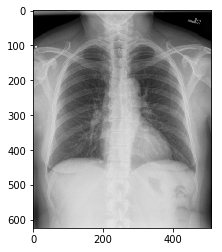

Truth: ['The lungs are clear. Heart size is normal. No pneumothorax. Calcified granuloma within the right lung base.']
Predicted: The heart is normal in size. The mediastinum is unremarkable. The lungs are clear.
BLEU-1 score = 0.230605


In [52]:
testid = "CXR2992_IM-1379-2002"
testf = testid + ".png"
image = test_features[testf].reshape((1,2048))
print(np.mean(image))
x=plt.imread(images + testf)
plt.imshow(x)
plt.show()

truth = descriptions[testid]
pred = greedySearch(image)
print("Truth:",truth)
print("Predicted:",pred)

# Evalaution
chencherry = SmoothingFunction()
print("BLEU-1 score = %f" % sentence_bleu([str(truth).split()],pred.split(), weights=(1,0,0,0), smoothing_function = chencherry.method1) )

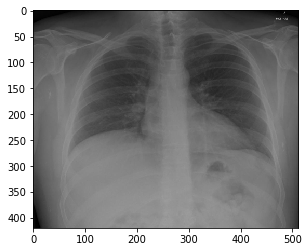

Image ID: CXR1684_IM-0449-1001
Truth: ['The heart is normal in size. The pulmonary vascularity is within normal limits in appearance. No focal air space opacities. No pleural effusions or pneumothorax. No acute bony abnormalities.']
Predicted: The heart is normal in size. The mediastinum is unremarkable. The lungs are clear.
BLEU-1 score = 0.171259
BLEU-2 score = 0.131738
BLEU-3 score = 0.114173
BLEU-4 score = 0.093414


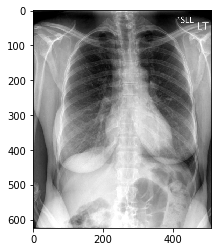

Image ID: CXR3002_IM-1388-1001
Truth: ['Cardiomediastinal silhouettes are within normal limits. Lungs are clear without focal consolidation, pneumothorax, or pleural effusion. Bony thorax is unremarkable.']
Predicted: The heart size and mediastinal contours appear within normal limits. No focal airspace consolidation, pleural effusion or pneumothorax. Scattered calcified granulomas bilaterally. No acute bony abnormalities.
BLEU-1 score = 0.269231
BLEU-2 score = 0.080000
BLEU-3 score = 0.041667
BLEU-4 score = 0.004348


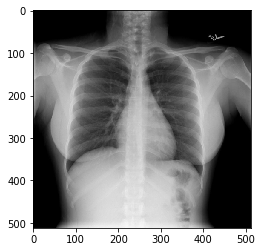

Image ID: CXR169_IM-0452-1001
Truth: ['The lungs and pleural spaces show no acute abnormality. Heart size and pulmonary vascularity within normal limits.']
Predicted: The heart is normal in size. The mediastinum is unremarkable. The lungs are clear.
BLEU-1 score = 0.115303
BLEU-2 score = 0.006209
BLEU-3 score = 0.006726
BLEU-4 score = 0.007337


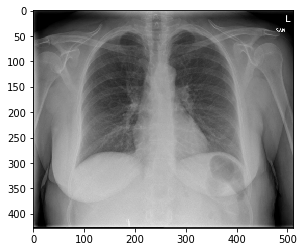

Image ID: CXR1560_IM-0366-1001
Truth: ['Normal heart. Clear lungs. No pneumothorax. No pleural effusion.']
Predicted: The heart is normal in size. The mediastinum is unremarkable. The lungs are clear.
BLEU-1 score = 0.000000
BLEU-2 score = 0.000000
BLEU-3 score = 0.000000
BLEU-4 score = 0.000000


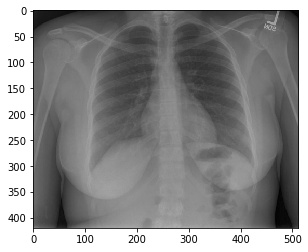

Image ID: CXR24_IM-0949-1001
Truth: ['Cardiomediastinal silhouette is within normal limits of size and appearance. The pulmonary vascularity is unremarkable. Lungs are expanded and clear of airspace disease. Negative for pneumothorax or pleural effusion. Limited bone evaluation reveals no acute abnormality. There is incompletely evaluated lumbar levoscoliosis.']
Predicted: The heart is normal in size. The mediastinum is unremarkable. The lungs are clear.
BLEU-1 score = 0.058001
BLEU-2 score = 0.010410
BLEU-3 score = 0.001128
BLEU-4 score = 0.001230


In [53]:
import random
image_set = list(test_images)
#random.shuffle(image_set)
for ti in image_set[:5]:
  chencherry = SmoothingFunction()
  testid = ti.split('.')[0]
  testf = ti
  image = test_features[testf].reshape((1,2048))
  #print(np.mean(image))
  x=plt.imread(images + testf)
  plt.imshow(x)
  plt.show()
  
  truth = descriptions[testid]
  pred = greedySearch(image)
  print("Image ID:", testid)
  print("Truth:",truth)
  print("Predicted:",pred)
  
  # Evalaution
  print("BLEU-1 score = %f" % sentence_bleu([str(truth).split()],pred.split(), weights=(1,0,0,0), smoothing_function = chencherry.method1) )
  print("BLEU-2 score = %f" % sentence_bleu([str(truth).split()],pred.split(), weights=(0,1,0,0), smoothing_function = chencherry.method1) )
  print("BLEU-3 score = %f" % sentence_bleu([str(truth).split()],pred.split(), weights=(0,0,1,0), smoothing_function = chencherry.method1) )
  print("BLEU-4 score = %f" % sentence_bleu([str(truth).split()],pred.split(), weights=(0,0,0,1), smoothing_function = chencherry.method1) )